<div style="width:50%; float:left;">
    <img src="support_files/AIBS_banner.png" width="430" align="left">
</div>

<div style="width:50%; float:right;">
    <img src="support_files/Dipde_Nick_final.png" width="100" height="100" align="right">
</div>

<div style="width:100%; float:left;">
    <hr>
</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h1>Example: Delay</h1>
<p> In this example, a single internal dipde population receives from a single external dipde population.  Additionally, the internal population receives an inhibitory recurrent connection from itself.  Try adjusting the duration of this delay, and look for a qualitative change in behavior.

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
%matplotlib notebook
from IPython.display import display
import dipde
assert dipde.__version__ == '0.2.1'
import matplotlib.pyplot as plt
import ipywidgets as ipw
import logging
from IPython.display import HTML
logging.disable(logging.CRITICAL)

<IPython.core.display.Javascript object>


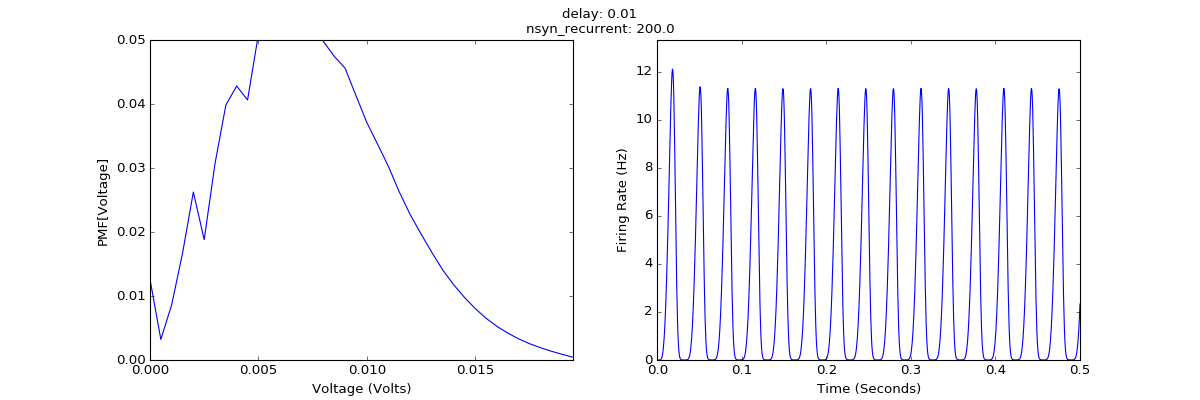

In [3]:
t0 = 0.
dt = .0005
dv = .0005

v_max = .02
v_min = 0
tf = .5
tau_m=.02
weights=.002

# Progress bar:
fltp = ipw.FloatProgress(min=0, max=int((tf-t0)/dt))
display(fltp)
def update_callback(n):
    fltp.value += 1

delay = ipw.FloatSlider(min=0,max=.01,step=dt,value=0, continuous_update=False)
nsyn_recurrent = ipw.FloatSlider(min=0,max=200,step=5,value=0, continuous_update=False)

@ipw.interact(delay=delay, nsyn_recurrent=nsyn_recurrent)
def f(delay, nsyn_recurrent):    
    fltp.value = 0

    b1 = dipde.ExternalPopulation(500)
    i1 = dipde.InternalPopulation(v_min=v_min, tau_m=tau_m, v_max=v_max, dv=dv, update_method='approx', tol=1e-10)
    b1_i1 = dipde.Connection(b1, i1, 1, weights=weights)
    i1_i1 = dipde.Connection(i1, i1, nsyn_recurrent, weights=-weights, delays=delay)
    network = dipde.Network([b1, i1], [b1_i1, i1_i1], update_callback=update_callback)
    simulation_configuration = dipde.SimulationConfiguration(dt, tf, t0=t0)
    simulation = dipde.Simulation(network=network, simulation_configuration=simulation_configuration)
    simulation.run()

    fig, ax = plt.subplots(1,2, figsize=(15,5))
    plt.suptitle('delay: %s\nnsyn_recurrent: %s' % (delay, nsyn_recurrent))
    i1.plot_probability_distribution(ax=ax[0], ylim=(0.,100*dv), color='b', show=False)
    i1.plot(xlim=(0,tf), ax=ax[1], color='b', show=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> This next cell will run the simulation with a callback enabled, that will record the values of the pvoltage distribution at every time point. Once you have settled on values for nsyn_recurrent and delay, you can explore how this density function vary over time as the simulation evolves.

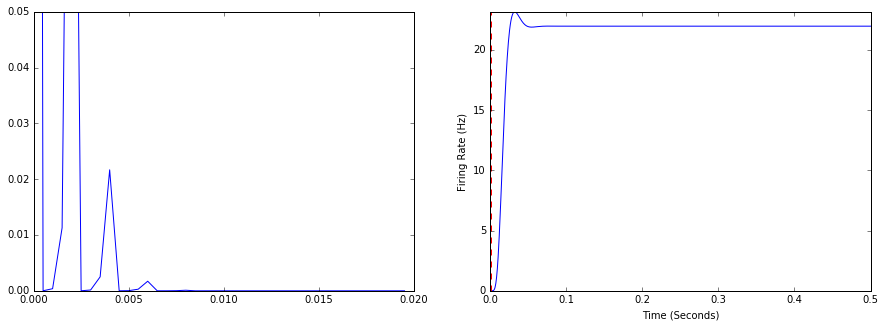

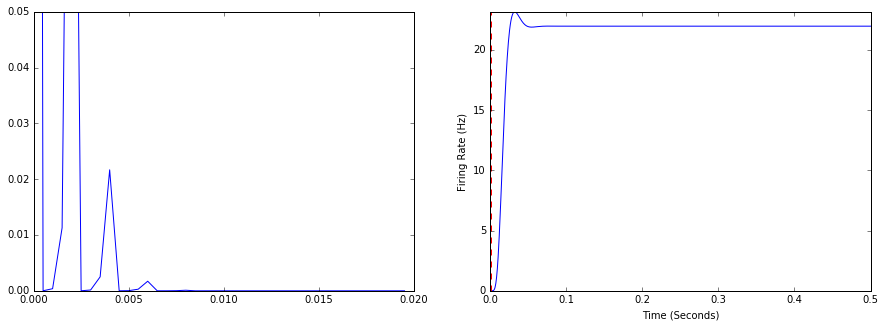

In [18]:
# Settings:
nsyn_recurrent = 0
delay = 0

# Progress bar:
f = ipw.FloatProgress(min=0, max=int((tf-t0)/dt))
display(f)
def update_callback(n):
    f.value += 1

# Probability distibution recorder:
class ProbabilityDistributionRecorder(object):
    
    def __init__(self):
        self.data = {}
        
    def update(self, population):
        self.data[population.simulation.ti] = population.pv.copy()

PDR = ProbabilityDistributionRecorder()
b1 = dipde.ExternalPopulation(500)
i1 = dipde.InternalPopulation(v_min=v_min, tau_m=tau_m, v_max=v_max, dv=dv, update_method='approx', tol=1e-10, update_callback=PDR.update)
b1_i1 = dipde.Connection(b1, i1, 1, weights=weights)
i1_i1 = dipde.Connection(i1, i1, nsyn_recurrent, weights=-weights, delays=delay)
network = dipde.Network([b1, i1], [b1_i1, i1_i1], update_callback=update_callback)
simulation_configuration = dipde.SimulationConfiguration(dt, tf, t0=t0)
simulation = dipde.Simulation(network=network, simulation_configuration=simulation_configuration)
simulation.run()

fig, ax = plt.subplots(1,2, figsize=(15,5))
L1, = ax[0].plot(i1.edges[:-1], PDR.data[1], 'b')
ax[0].set_ylim((0.,100*dv))
i1.plot(xlim=(0,tf), ax=ax[1], color='b', show=False, ylim=[0, max(i1.firing_rate_record)])
L2, = ax[1].plot([dt, dt], (0, max(i1.firing_rate_record)), 'r--')
ax[1].set_ylim((0, max(i1.firing_rate_record)))

t = ipw.FloatSlider(min=dt, max=tf, step=2*dt,value=dt, continuous_update=False)
@ipw.interact(t=t)
def f(t):
    L1.set_ydata(PDR.data[round(t/dt)])
    L2.set_xdata([t, t])
    display(fig)
    